In [84]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from surprise import SVD, SVDpp, NormalPredictor, KNNBasic, BaselineOnly
from surprise import Reader, Dataset, accuracy
from surprise.model_selection import train_test_split
import pickle

import warnings
warnings.filterwarnings('ignore')

In [6]:
train_df = pd.read_csv('../data/train.csv', nrows=20000)

In [7]:
train_df.shape

(20000, 4)

In [8]:
train_df.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [10]:
train_df.drop('timestamp', axis=1, inplace=True)

In [11]:
print("Number of userId's:", train_df['userId'].nunique())
print("Number of movieId's:", train_df['movieId'].nunique())

Number of userId's: 16610
Number of movieId's: 5177


In [12]:
train_df.isna().sum()

userId     0
movieId    0
rating     0
dtype: int64

There's no missing data in our dataset.

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   userId   20000 non-null  int64  
 1   movieId  20000 non-null  int64  
 2   rating   20000 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 468.9 KB


The data is in the form of numeric values only.

## Ratings Distribution

In [14]:
ratings = train_df['rating'].value_counts().sort_index()

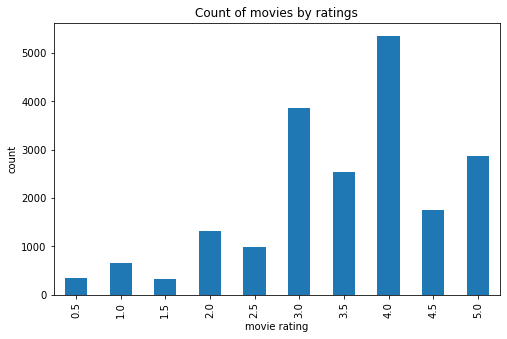

In [15]:
plt.figure(figsize=(8,5))
ratings.plot(kind='bar')
plt.ylabel('count')
plt.xlabel('movie rating')
plt.title('Count of movies by ratings');

There are more movies with ratings of 4.0, followed by 3.0, then 5.0. The issue here is that a movie may have been watched by one user and they might have given it a rating of 5.0. To curb this issue, there might be a need to consider only a movie whereby there we only 100 or more users who have watched the movie.

In [30]:
no_of_ratings = train_df.groupby('movieId').count()['rating']

In [32]:
no_of_ratings = no_of_ratings[no_of_ratings >= 10]

In [33]:
no_of_ratings

movieId
1         49
2         11
3         10
6         22
10        21
          ..
122886    10
122904    11
128360    10
134130    12
134853    10
Name: rating, Length: 498, dtype: int64

In [34]:
no_of_ratings.index

Int64Index([     1,      2,      3,      6,     10,     16,     17,     19,
                21,     25,
            ...
            112556, 112852, 115617, 116797, 122882, 122886, 122904, 128360,
            134130, 134853],
           dtype='int64', name='movieId', length=498)

In [35]:
new_ratings = train_df[train_df['movieId'].isin(no_of_ratings.index)]

In [36]:
len(new_ratings)

9072

In [37]:
ratings = new_ratings['rating'].value_counts().sort_index()

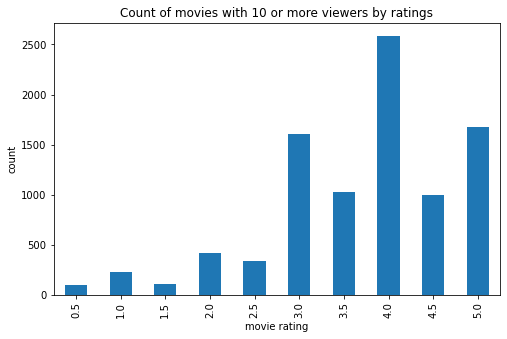

In [38]:
plt.figure(figsize=(8,5))
ratings.plot(kind='bar')
plt.ylabel('count')
plt.xlabel('movie rating')
plt.title('Count of movies with 10 or more viewers by ratings');

In [39]:
# Average rating of movies in the database
avg_rating = new_ratings.groupby('movieId')['rating'].mean()

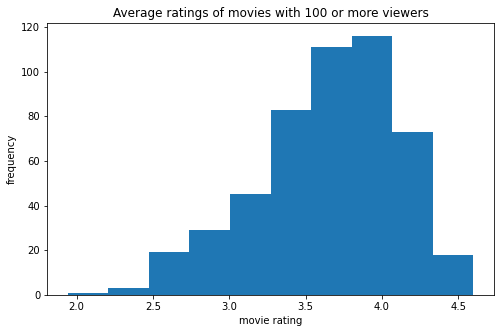

In [40]:
plt.figure(figsize=(8,5))
avg_rating.plot(kind='hist')
plt.ylabel('frequency')
plt.xlabel('movie rating')
plt.title('Average ratings of movies with 100 or more viewers');

There's a high distribution of movies in the region of 3.0 to 4.0.

# Modelling

In [41]:
reader = Reader(sep=',', rating_scale=(0, 5))

In [43]:
data = Dataset.load_from_df(train_df, reader=reader)

In [44]:
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

In [46]:
algo = SVD()

In [47]:
algo.fit(trainset)

In [48]:
predictions = algo.test(testset)

In [50]:
rating_pred = accuracy.rmse(predictions)

RMSE: 1.0423


In [74]:
models = ['SVD', 'SVDpp', 'NormalPredictor', 'KNNBasic', 'BaselineOnly']
performance = [] # empty list to capture rmse

In [75]:
for model in [SVD, SVDpp, NormalPredictor, KNNBasic, BaselineOnly]:
    
    # Create an instance of the model
    algo = model()
    # Fit the model to the training data
    algo.fit(trainset)
    # Generate predictions
    predictions = algo.test(testset)
    # Compare predictions against actuals
    rating_pred = accuracy.rmse(predictions)
    # Extract only the name of the model
    performance.append(rating_pred)  
    

RMSE: 1.0413
RMSE: 1.0382
RMSE: 1.4738
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0812
Estimating biases using als...
RMSE: 1.0417


In [76]:
performance

[1.0413387522368767,
 1.038223782768511,
 1.4738234339121397,
 1.0812342165835815,
 1.0417351344067918]

In [77]:
results = pd.DataFrame(data=performance, columns=['rmse'], index=models)

In [82]:
results.sort_values('rmse', inplace=True)

In [83]:
results

,rmse
SVDpp,1.038224
SVD,1.041339
BaselineOnly,1.041735
KNNBasic,1.081234
NormalPredictor,1.473823


Based on the results, SVDpp seems to be performing the best.

In [85]:
algo = SVDpp()

In [86]:
algo.fit(trainset)

In [87]:
filename = 'mySVDpp.pkl'
pickle.dump(algo, open(filename, 'wb'))